In [ ]:
!pip install datasets

In [2]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("Ozziey/poems_dataset")
df = pd.DataFrame(dataset['train'])
print(df.head())


d:\Kc\Clarkson\IA653_Natural_Language_Processing\Final_Project\2024_IA653_Kranthi_Shylendra\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 450/450 [00:00<00:00, 1351.21 examples/s]

                                        poem content  pred    label     score  \
0  Let the bird of loudest lay\r\nOn the sole Ara...     5  sadness  0.650738   
1  Sir Charles into my chamber coming in,\r\nWhen...     0    anger  0.264296   
2  Our vice runs beyond all that old men saw,\r\n...     0    anger  0.758054   
3  Lo I the man, whose Muse whilome did maske,\r\...     0    anger  0.896280   
4  Long have I longd to see my love againe,\r\nSt...     5  sadness  0.600543   

      anger   disgust      fear       joy   neutral   sadness  surprise  \
0  0.133402  0.076618  0.094706  0.006762  0.032960  0.650738  0.004814   
1  0.264296  0.145707  0.057977  0.262715  0.019884  0.244457  0.004963   
2  0.758054  0.210444  0.003690  0.001755  0.013997  0.011483  0.000578   
3  0.896280  0.009259  0.004949  0.002320  0.007623  0.078088  0.001481   
4  0.027077  0.036344  0.075487  0.017212  0.187106  0.600543  0.056230   

           age                  type  
0  Renaissance  Mytholo

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA

Some visualizations to analyze the dataset: it shows the distribution of emotions using a count plot, examines the variation in poem lengths with a histogram, and compares average scores across emotion labels using a bar plot. These insights help understand the dataset's structure and any patterns present.

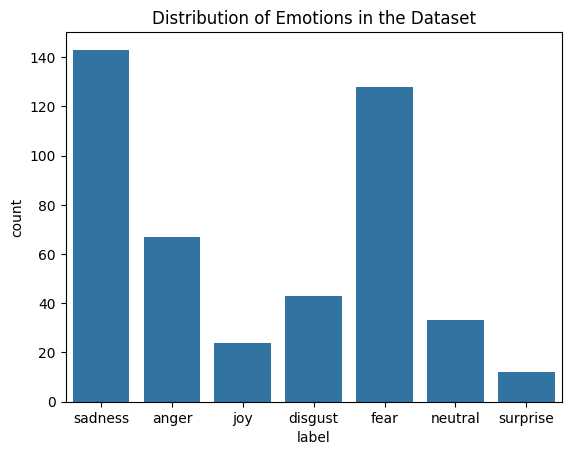

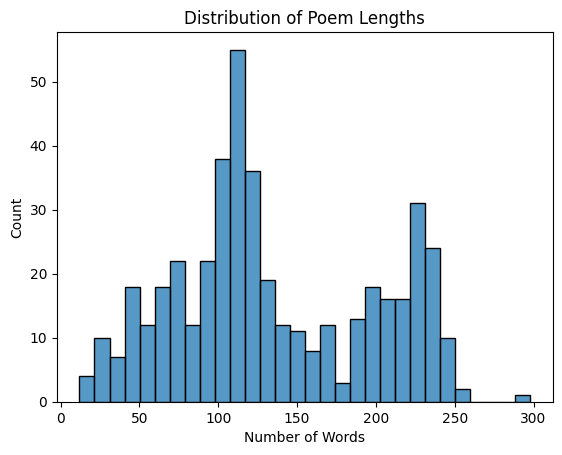

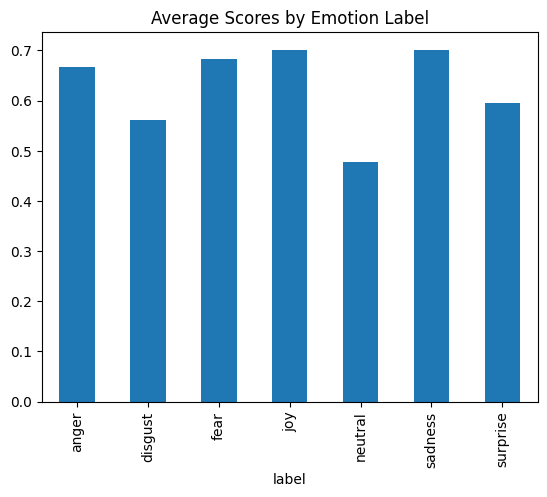

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df)
plt.title('Distribution of Emotions in the Dataset')
plt.show()

df['poem_length'] = df['poem content'].apply(lambda x: len(x.split()))
sns.histplot(df['poem_length'], bins=30)
plt.title('Distribution of Poem Lengths')
plt.xlabel('Number of Words')
plt.show()

df.groupby('label')['score'].mean().plot(kind='bar')
plt.title('Average Scores by Emotion Label')
plt.show()


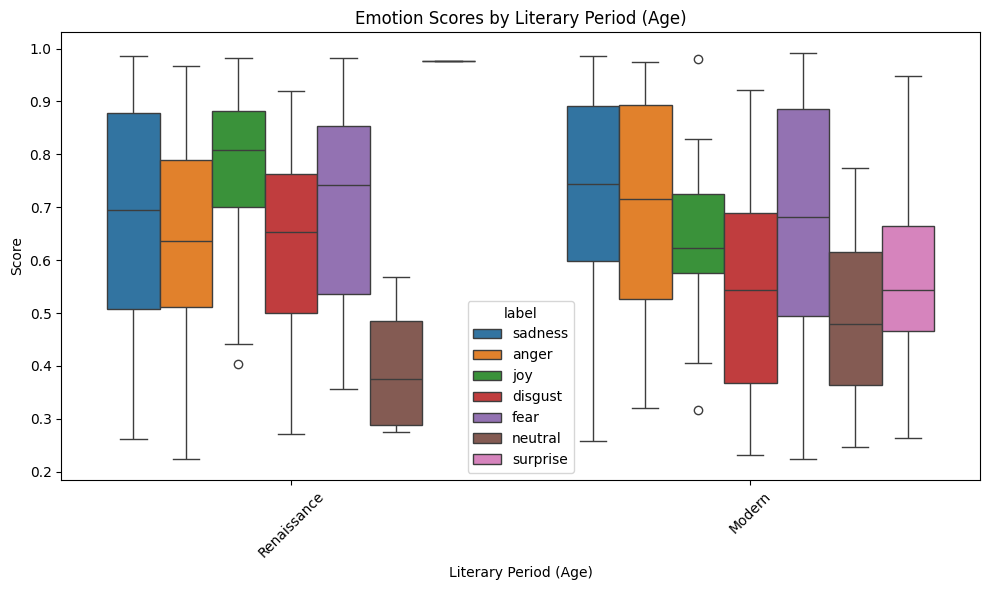

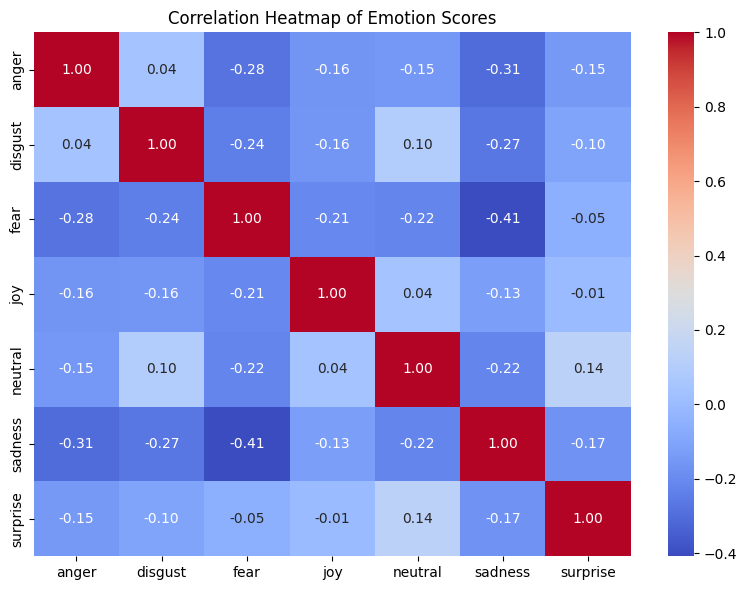

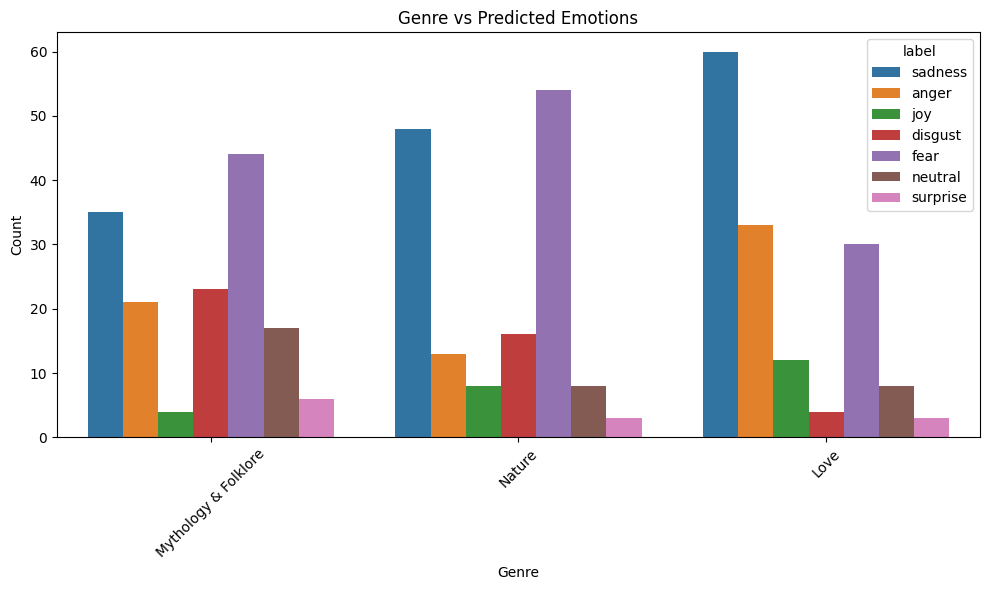

In [6]:
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df_melted = df.melt(id_vars=['label'], value_vars=emotion_columns, var_name='Emotion', value_name='Score')

plt.figure(figsize=(10, 6))
sns.boxplot(x='age', y='score', hue='label', data=df)
plt.title('Emotion Scores by Literary Period (Age)')
plt.xlabel('Literary Period (Age)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
correlation_matrix = df[emotion_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Emotion Scores')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='label', data=df, order=df['type'].value_counts().index)
plt.title('Genre vs Predicted Emotions')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Preprocessing

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

In [ ]:
import re
import spacy

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\r\n', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

nlp = spacy.load("en_core_web_sm")

df['cleaned_poem'] = df['poem content'].apply(preprocess_text)

def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

df['tokens'] = df['cleaned_poem'].apply(tokenize_text)
print(df[['poem content', 'cleaned_poem', 'tokens']].head())


                                        poem content  \
0  Let the bird of loudest lay\r\nOn the sole Ara...   
1  Sir Charles into my chamber coming in,\r\nWhen...   
2  Our vice runs beyond all that old men saw,\r\n...   
3  Lo I the man, whose Muse whilome did maske,\r\...   
4  Long have I longd to see my love againe,\r\nSt...   

                                        cleaned_poem  \
0  let the bird of loudest lay on the sole arabia...   
1  sir charles into my chamber coming in when i w...   
2  our vice runs beyond all that old men saw and ...   
3  lo i the man whose muse whilome did maske as t...   
4  long have i longd to see my love againe still ...   

                                              tokens  
0  [let, the, bird, of, loudest, lay, on, the, so...  
1  [sir, charles, into, my, chamber, coming, in, ...  
2  [our, vice, runs, beyond, all, that, old, men,...  
3  [lo, i, the, man, whose, muse, whilome, did, m...  
4  [long, have, i, longd, to, see, my, love, agai..

Naive Bayes Model for Text Classification

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_poem'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        14
     disgust       0.00      0.00      0.00        12
        fear       0.38      0.70      0.49        23
         joy       0.00      0.00      0.00         8
     neutral       0.00      0.00      0.00         5
     sadness       0.40      0.72      0.51        25
    surprise       0.00      0.00      0.00         3

    accuracy                           0.38        90
   macro avg       0.11      0.20      0.14        90
weighted avg       0.21      0.38      0.27        90



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 N-Gram Model for Text Generation

In [8]:
from nltk.util import ngrams
from collections import defaultdict

def simple_tokenize(text):
    return text.split()

def train_ngram_model(poems, n=2):
    ngram_model = defaultdict(lambda: defaultdict(int))
    for poem in poems:
        tokens = simple_tokenize(poem)
        for i in range(len(tokens) - n):
            ngram_model[tuple(tokens[i:i + n - 1])][tokens[i + n - 1]] += 1
    return ngram_model

import random

def filter_poems_by_emotion(df, emotion):
    return df[df['label'] == emotion]['cleaned_poem']

def generate_poetic_text(ngram_model, seed_text, word_count):
    current_words = tuple(seed_text.split()[:2])
    generated_text = list(current_words)

    for _ in range(word_count - 2):
        if current_words in ngram_model:
            next_word = random.choices(
                list(ngram_model[current_words].keys()),
                list(ngram_model[current_words].values())
            )[0]
            generated_text.append(next_word)
            current_words = (current_words[1], next_word)
        else:
            break
    return ' '.join(generated_text)


In [13]:

emotion = "sadness"
word_count = 20
seed_text = "the moon is beautiful"

emotion_poems = filter_poems_by_emotion(df, emotion)
ngram_model = train_ngram_model(emotion_poems, n=3)

poetic_sentence = generate_poetic_text(ngram_model, seed_text, word_count)
print(poetic_sentence)


the moon thy wishes then dare not be with you through the sweet bitter under this marble figure with wings


In [14]:
emotion = "joy"
word_count <= 20
seed_text = "the moon is beautiful"

emotion_poems = filter_poems_by_emotion(df, emotion)
ngram_model = train_ngram_model(emotion_poems, n=3)

poetic_sentence = generate_poetic_text(ngram_model, seed_text, word_count)
print(poetic_sentence)

the moon light her hubby dear loves to live i the sun seeking the food he eats and pleased with


RNN and LSTM Models

In [15]:
import torch
import torch.nn as nn

def build_vocab(texts):
    word_to_idx = {}
    idx_to_word = {}
    idx = 0
    for text in texts:
        for word in text.split():
            if word not in word_to_idx:
                word_to_idx[word] = idx
                idx_to_word[idx] = word
                idx += 1
    return word_to_idx, idx_to_word

def filter_and_prepare_data(df, emotion):
    poems = df[df['label'] == emotion]['cleaned_poem'].tolist()
    word_to_idx, idx_to_word = build_vocab(poems)
    return poems, word_to_idx, idx_to_word

def sentence_to_indices(sentence, word_to_idx):
    return [word_to_idx[word] for word in sentence.split() if word in word_to_idx]

def generate_text(model, seed_text, word_count, idx_to_word, word_to_idx, device):
    model.eval()
    words = seed_text.split()
    input_indices = torch.tensor([sentence_to_indices(seed_text, word_to_idx)], device=device)

    for _ in range(word_count - len(words)):
        with torch.no_grad():
            output = model(input_indices)
            _, predicted = torch.max(output, dim=1)
            next_word = idx_to_word[predicted.item()]
            words.append(next_word)
            input_indices = torch.tensor([[predicted.item()]], device=device)

    return ' '.join(words)

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:

emotion = "sadness"
seed_text = "the moon is beautiful"
word_count = 20

poems, word_to_idx, idx_to_word = filter_and_prepare_data(df, emotion)
vocab_size = len(word_to_idx)

embed_size = 128
hidden_size = 256
output_size = vocab_size

rnn_model = RNNModel(vocab_size, embed_size, hidden_size, output_size).to(device)
lstm_model = LSTMModel(vocab_size, embed_size, hidden_size, output_size).to(device)

poetic_sentence_rnn = generate_text(rnn_model, seed_text, word_count, idx_to_word, word_to_idx, device)
print("RNN Generated Text with Emotion:", poetic_sentence_rnn)

poetic_sentence_lstm = generate_text(lstm_model, seed_text, word_count, idx_to_word, word_to_idx, device)
print("LSTM Generated Text with Emotion:", poetic_sentence_lstm)


RNN Generated Text with Emotion: the moon is beautiful husband twisted fedde bough lucks desires honeybee worst strength saints cyclones ii cythera dirt difficult swallows
LSTM Generated Text with Emotion: the moon is beautiful gyb subdue mutual sweated anthem hearts print pelides tyrant expense others grief faynting delight growth dazzle


In [17]:

emotion = "joy"
seed_text = "the moon is beautiful"
word_count = 20

poems, word_to_idx, idx_to_word = filter_and_prepare_data(df, emotion)
vocab_size = len(word_to_idx)

embed_size = 128
hidden_size = 256
output_size = vocab_size

rnn_model = RNNModel(vocab_size, embed_size, hidden_size, output_size).to(device)
lstm_model = LSTMModel(vocab_size, embed_size, hidden_size, output_size).to(device)

poetic_sentence_rnn = generate_text(rnn_model, seed_text, word_count, idx_to_word, word_to_idx, device)
print("RNN Generated Text with Emotion:", poetic_sentence_rnn)

poetic_sentence_lstm = generate_text(lstm_model, seed_text, word_count, idx_to_word, word_to_idx, device)
print("LSTM Generated Text with Emotion:", poetic_sentence_lstm)


RNN Generated Text with Emotion: the moon is beautiful life running fallen art gifts suffice brief souls twinkling cheer wish fall know in what circes
LSTM Generated Text with Emotion: the moon is beautiful first springs sake was springs sake was springs sake was springs sake was springs sake was


In [ ]:
seed_text = "the moon is beautiful"
print("\nGenerated Text with RNN:")
print(generate_text(rnn_model, seed_text, word_count=30, idx_to_word=idx_to_word, word_to_idx=word_to_idx, device=device))

print("\nGenerated Text with LSTM:")
print(generate_text(lstm_model, seed_text, word_count=30, idx_to_word=idx_to_word, word_to_idx=word_to_idx, device=device))

In [ ]:

emotion = "joy"
seed_text = "the moon is beautiful"
word_count = 30

poems, word_to_idx, idx_to_word = filter_and_prepare_data(df, emotion)
vocab_size = len(word_to_idx)

embed_size = 128
hidden_size = 256
output_size = vocab_size

rnn_model = RNNModel(vocab_size, embed_size, hidden_size, output_size).to(device)
lstm_model = LSTMModel(vocab_size, embed_size, hidden_size, output_size).to(device)

poetic_sentence_rnn = generate_text(rnn_model, seed_text, word_count, idx_to_word, word_to_idx, device)
print("RNN Generated Text with Emotion:", poetic_sentence_rnn)

poetic_sentence_lstm = generate_text(lstm_model, seed_text, word_count, idx_to_word, word_to_idx, device)
print("LSTM Generated Text with Emotion:", poetic_sentence_lstm)


RNN Generated Text with Emotion: the moon is beautiful why rivers observe breeze content never back lost make some admired ornithologists bag built flowers blow hereafter smells dull he easily has nothing revels lucifer cose
LSTM Generated Text with Emotion: the moon is beautiful browse discord impotence dark melodious speak second oasis bliss fie skilful prepare manger seem king sit mark briar buttercups manger seem king sit mark briar buttercups


Transformers Model

In [ ]:
!pip install transformers datasets torch


In [29]:
import pandas as pd
from datasets import load_dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

dataset = load_dataset("Ozziey/poems_dataset")
df = pd.DataFrame(dataset['train'])

def prepare_dataset(poems, labels):
    return [f"<bos> {label} {poem} <eos>" for label, poem in zip(labels, poems)]

poems = df['poem content'].tolist()
labels = df['label'].tolist()
formatted_texts = prepare_dataset(poems, labels)

with open("/content/drive/MyDrive/IA653_Natural_Language_Processing/poem_dataset.txt", "w") as f:
    f.write("\n".join(formatted_texts))

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

special_tokens = {'pad_token': '<pad>', 'bos_token': '<bos>', 'eos_token': '<eos>'}
tokenizer.add_special_tokens(special_tokens)
model.resize_token_embeddings(len(tokenizer))

def load_poem_dataset(file_path, tokenizer, block_size=128):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )

train_dataset = load_poem_dataset("/content/drive/MyDrive/IA653_Natural_Language_Processing/poem_dataset.txt", tokenizer)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

training_args = TrainingArguments(
    output_dir="./poetry-transformer",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=5e-5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

trainer.train()

model.save_pretrained("./poetry-transformer")
tokenizer.save_pretrained("./poetry-transformer")

def generate_poem(seed_text, emotion, model, tokenizer, max_length=50):
    model.eval()
    input_text = f"<bos> {emotion} {seed_text}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device)

    output = model.generate(
        input_ids=input_ids,
        max_length=max_length,
        num_return_sequences=1,
        temperature=0.7,
        top_k=50,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

emotion = "joy"
seed_text = "the moon is beautiful"
generated_poem = generate_poem(seed_text, emotion, model, tokenizer)
print("Generated Poem with Emotion:")
print(generated_poem)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
50,4.487900
100,4.425700
150,4.324800
200,4.348700
250,4.058200
300,3.920600
350,3.911800
400,3.933700
450,3.744800
500,3.741300


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Generated Poem with Emotion:
 joy the moon is beautiful,
And the stars are bright,
And the moon is full of light. 


In [30]:
emotion = "sadness"
seed_text = "the moon is beautiful"
generated_poem = generate_poem(seed_text, emotion, model, tokenizer)
print("Generated Poem with Emotion:")
print(generated_poem)

Generated Poem with Emotion:
 sadness the moon is beautiful
And the stars are bright and clear
And the moon is full of love
                           


In [31]:
def save_model(model, model_name):
    save_path = f"/content/drive/MyDrive/IA653_Natural_Language_Processing/{model_name}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

In [33]:
save_model(rnn_model, "rnn_model")
save_model(lstm_model, "lstm_model")

Model saved to /content/drive/MyDrive/IA653_Natural_Language_Processing/rnn_model.pth
Model saved to /content/drive/MyDrive/IA653_Natural_Language_Processing/lstm_model.pth
